In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# 1. Importing Necessary Libraries

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer         #Apply different preprocessing techniques to specific columns
from sklearn.pipeline import Pipeline                 # Multiple data transformation and modeling steps into a single workflow
from sklearn.linear_model import LogisticRegression   # for Logistic Regression model
from xgboost import XGBClassifier                     # for XGBClassifier model
from sklearn.ensemble import RandomForestClassifier   # for Random forest classifier model
from sklearn.model_selection import RandomizedSearchCV # for hyperparameter tuning
from  lightgbm import LGBMClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from sklearn import set_config 


# 2. Loading the Data

In [41]:
train_filepath = "/kaggle/input/System-Threat-Forecaster/train.csv"
test_filepath = "/kaggle/input/System-Threat-Forecaster/test.csv"

In [42]:
train_data= pd.read_csv(train_filepath)

test_set = pd.read_csv(test_filepath)

In [43]:
print(train_data.shape)

(100000, 76)


In [44]:
print(train_data.head(5))

                          MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.275.1003.0           0                      7.0   
1   4.18.1807.18075     1.273.1465.0           0                      7.0   
2   4.18.1807.18075     1.275.1546.0           0                      7.0   
3  4.12.17007.18011     1.275.1141.0           0                      7.0   
4    4.13.17134.228     1.275.1283.0           0                      7.0   

   IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  \
0                     0            53447.0               

In [45]:
print(train_data.describe())

       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%         53447.000000         

# **3. Perform Exploratory Data Analysis**

In [46]:
# Shape of the Data
print(train_data.shape)

(100000, 76)


In [47]:
# Insight of the Data

print(train_data.head())

                          MachineID   ProductName EngineVersion  \
0  f541bae429089117c4aac39c90dd3416  win8defender   1.1.15200.1   
1  dc2b14d9ce3a0ce4050bb640190f2ca5  win8defender   1.1.15100.1   
2  fd20c5f010e9c5f91ad1c6b3e0da68a0  win8defender   1.1.15200.1   
3  38711eae85eb77a72ec5dfdf27eb2a76  win8defender   1.1.15200.1   
4  32607c9a543a9214e2c7e45800ed4849  win8defender   1.1.15200.1   

         AppVersion SignatureVersion  IsBetaUser  RealTimeProtectionState  \
0   4.18.1807.18075     1.275.1003.0           0                      7.0   
1   4.18.1807.18075     1.273.1465.0           0                      7.0   
2   4.18.1807.18075     1.275.1546.0           0                      7.0   
3  4.12.17007.18011     1.275.1141.0           0                      7.0   
4    4.13.17134.228     1.275.1283.0           0                      7.0   

   IsPassiveModeEnabled  AntivirusConfigID  NumAntivirusProductsInstalled  \
0                     0            53447.0               

In [48]:
#Print information about the DataFrame
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

# Missing values

In [49]:
# #Find the missing value in train dataset
miss_vals = train_data.isna().sum().sort_values(ascending = False)
print('Total no of missing values:', miss_vals.sum())

Total no of missing values: 6533


In [50]:
#Display columns with missing values and in percentage
miss_vals_percent = miss_vals[miss_vals !=0]/len(train_data)*100
missing_data = pd.DataFrame({'miss_vals': miss_vals, 'Percentage': miss_vals_percent})
missing_data = missing_data[missing_data['miss_vals'] > 0]
print(missing_data.sort_values(by='Percentage', ascending=False))

                                    miss_vals  Percentage
SMode                                     981       0.981
CityID                                    623       0.623
IsGamer                                   559       0.559
RegionIdentifier                          559       0.559
InternalBatteryNumberOfCharges            515       0.515
FirmwareManufacturerID                    376       0.376
FirmwareVersionID                         334       0.334
IsFlightsDisabled                         326       0.326
OEMModelID                                228       0.228
OEMNameID                                 212       0.212
FirewallEnabled                           166       0.166
TotalPhysicalRAMMB                        151       0.151
IsAlwaysOnAlwaysConnectedCapable          134       0.134
OSInstallLanguageID                       113       0.113
PrimaryDiskCapacityMB                     110       0.110
SystemVolumeCapacityMB                    110       0.110
IEVersionID   

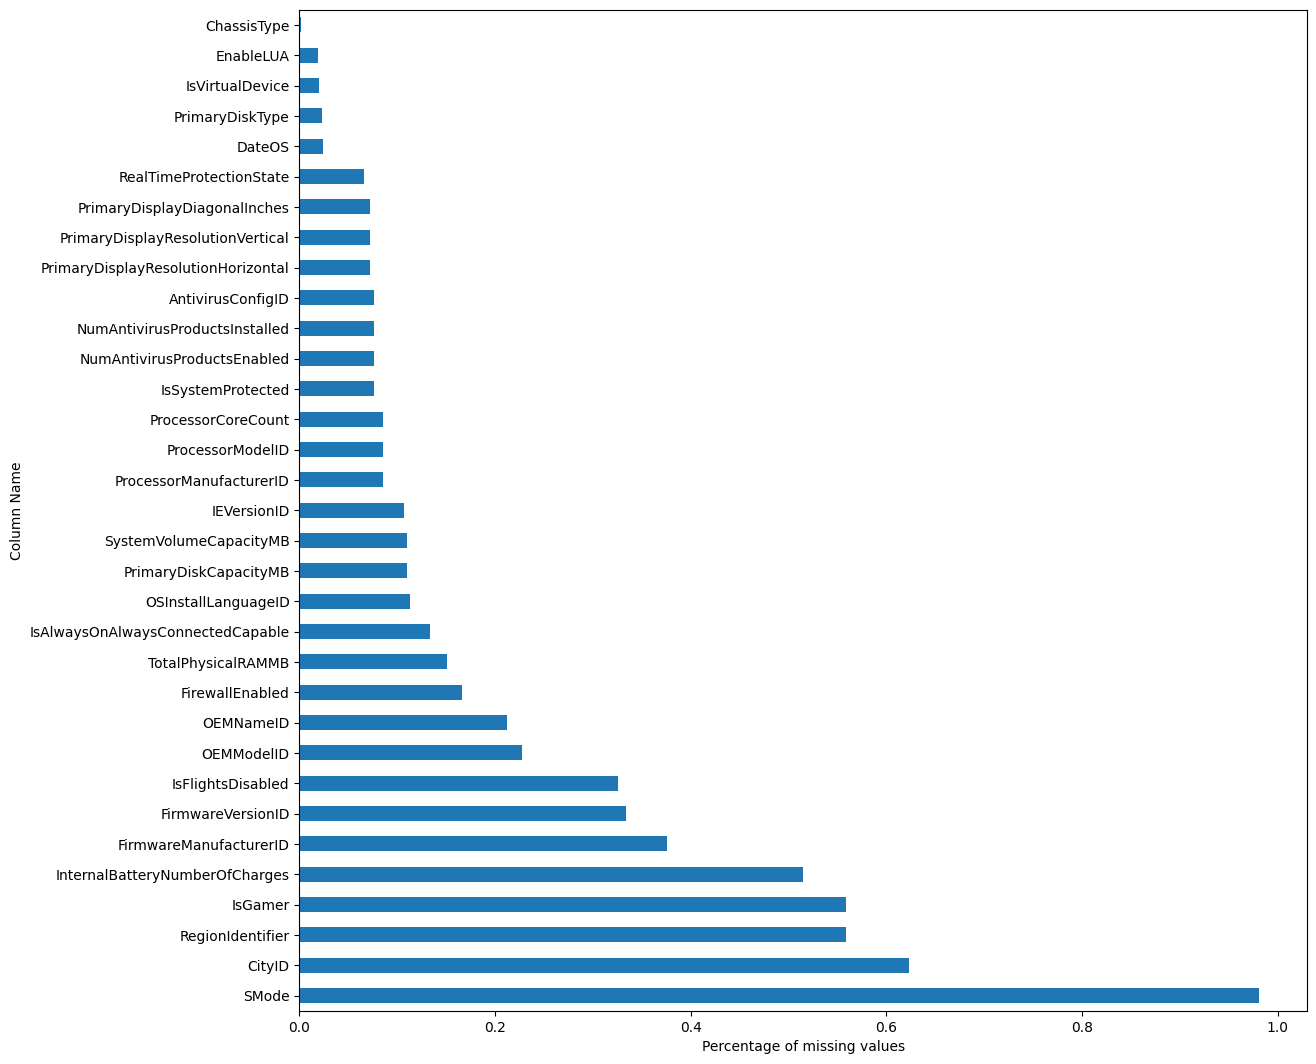

In [84]:
#ploting horizontal bar
miss_vals_percent[miss_vals !=0].plot(kind = 'barh' , figsize = (13,13));
plt.ylabel('Column Name')
plt.xlabel('Percentage of missing values');

**Conclusion:**

There are top 5 columns which have more 500+ missing values.

1. SMode
2. CityID
3. IsGamer
4. RegionIdentifier
5. InternalBatteryNumberOfCharges


In [52]:
# Unique values
unique_col = train_data.nunique().sort_values(ascending = False)
unique_col

MachineID                      99835
SystemVolumeCapacityMB         46188
CityID                         16047
OEMModelID                     15952
FirmwareVersionID              12299
                               ...  
IsPortableOS                       2
target                             2
IsFlightsDisabled                  1
AutoSampleSubmissionEnabled        1
IsBetaUser                         1
Length: 76, dtype: int64

Conclusion:

1. MachineID have 99835 unique vlaues which is identifier columns and may not useful during model.
2. SystemVolumeCapacityMB, CityID, OEMModel ID, Firmwareversion Id which have thousands unique values and have high cardinality.
3. IsPortableOS, target  columns have only two unique values which have binary classification problem(0,1).

In [53]:
tar_count = train_data['target'].value_counts()
tar_count

target
1    50525
0    49475
Name: count, dtype: int64

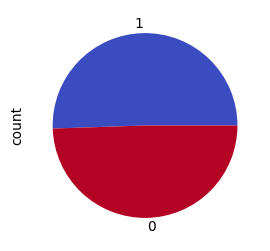

In [54]:
train_data['target'].value_counts().plot(kind="pie", figsize=(7,3), colormap="coolwarm");

The target column is nearly balanced so no resampling techniques are needed.

In [55]:
#Column type distribution

categorical_col = list(train_data.loc[:, train_data.dtypes =="object"].columns)

# Numerical and Binary type distribution
numerical_and_binary_col = list(train_data.loc[:, train_data.dtypes !="object"].columns)

numerical_col = numerical_and_binary_col

categorical_col.remove("MachineID") # MachineID is a unique values

# seperate the numeric and binary columns
binary_col = []
for col in (numerical_and_binary_col):
    if train_data[col].nunique() == 2:
        binary_col.append(col)
        numerical_col.remove(col)


Total no of Binary column: 11
Total no of Numerical column: 37
Total no of Categorical column: 27


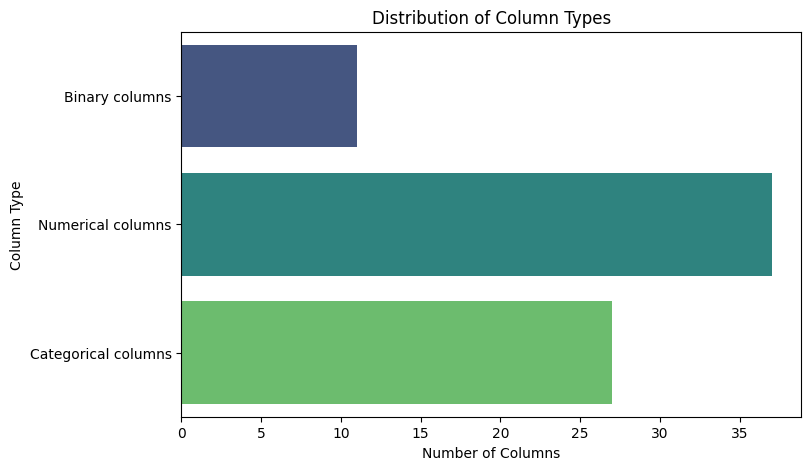

In [56]:
print('Total no of Binary column:',len(binary_col))
print('Total no of Numerical column:',len(numerical_col))
print('Total no of Categorical column:',len(categorical_col))

# Create a DataFrame for column types
type_df = pd.DataFrame([['Binary columns', len(binary_col)],['Numerical columns', len(numerical_col)],
                        ['Categorical columns', len(categorical_col)]], columns=['Type', 'Column count'])

# Set the figure size
plt.figure(figsize=(8, 5))

# Create a horizontal bar plot
sns.barplot(data=type_df, y="Type", x="Column count", palette="viridis")

# Add labels and title
plt.xlabel("Number of Columns")
plt.ylabel("Column Type")
plt.title("Distribution of Column Types")
plt.show()


In [57]:
#numerical type summary
num_summary = train_data.describe().T
num_summary

,count,mean,std,min,25%,50%,75%,max
IsBetaUser,100000.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00
RealTimeProtectionState,99934.0,6.848430e+00,1.015166e+00,0.0,7.0,7.0,7.000000e+00,8.000000e+00
IsPassiveModeEnabled,100000.0,1.762000e-02,1.315664e-01,0.0,0.0,0.0,0.000000e+00,1.000000e+00
AntivirusConfigID,99924.0,4.797571e+04,1.380332e+04,39.0,49480.0,53447.0,5.344700e+04,7.049000e+04
NumAntivirusProductsInstalled,99924.0,1.326528e+00,5.206814e-01,1.0,1.0,1.0,2.000000e+00,5.000000e+00
NumAntivirusProductsEnabled,99924.0,1.018264e+00,1.552909e-01,0.0,1.0,1.0,1.000000e+00,4.000000e+00
HasTpm,100000.0,9.967800e-01,5.665389e-02,0.0,1.0,1.0,1.000000e+00,1.000000e+00
CountryID,100000.0,1.080788e+02,6.306215e+01,1.0,51.0,97.0,1.620000e+02,2.220000e+02
CityID,99377.0,8.102994e+04,4.894403e+04,7.0,36694.0,82373.0,1.228350e+05,1.679570e+05
GeoRegionID,100000.0,1.697416e+02,8.918893e+01,1.0,89.0,181.0,2.670000e+02,2.960000e+02


In [58]:
# Compute correlation matrix with numeric features only
corr_matrix = train_data.corr(numeric_only=True)

# Identify numeric columns (excluding binary ones)
numeric_cols = [col for col in train_data.select_dtypes(include=['int64', 'float64']).columns 
                if train_data[col].nunique() > 2]  # Exclude binary columns

# Filter correlation matrix to include only non-binary numeric columns
filtered_corr_matrix = corr_matrix.loc[numeric_cols, numeric_cols]

# Display the filtered correlation matrix
filtered_corr_matrix


,RealTimeProtectionState,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,CountryID,CityID,GeoRegionID,LocaleEnglishNameID,OSBuildNumber,OSProductSuite,...,PrimaryDisplayResolutionHorizontal,PrimaryDisplayResolutionVertical,InternalBatteryNumberOfCharges,OSBuildNumberOnly,OSBuildRevisionOnly,OSInstallLanguageID,OSUILocaleID,FirmwareManufacturerID,FirmwareVersionID,RegionIdentifier
RealTimeProtectionState,1.000000,0.107907,-0.184396,-0.001299,0.010743,-0.001671,0.013603,0.002851,-0.032420,-0.010316,...,-0.021575,-0.014395,-0.002948,-0.038210,0.024664,-0.011902,-0.012716,0.010112,0.008421,-0.009479
AntivirusConfigID,0.107907,1.000000,-0.647222,-0.115021,0.008457,-0.000666,0.017477,-0.077096,-0.039585,-0.055607,...,0.043797,0.054791,0.013322,-0.043079,0.026102,0.013605,0.011826,-0.009623,-0.020802,-0.008294
NumAntivirusProductsInstalled,-0.184396,-0.647222,1.000000,0.273791,-0.017957,0.003512,-0.042795,0.041475,-0.005869,0.173563,...,-0.042282,-0.070245,-0.083783,-0.012619,-0.017848,0.008881,0.008324,0.054231,0.047223,0.028845
NumAntivirusProductsEnabled,-0.001299,-0.115021,0.273791,1.000000,-0.014795,0.006448,-0.022393,-0.015629,-0.071987,0.027037,...,-0.003743,-0.008628,-0.008460,-0.050397,0.021390,0.031073,0.029986,0.015469,0.003158,0.000937
CountryID,0.010743,0.008457,-0.017957,-0.014795,1.000000,-0.000624,0.597061,0.040761,0.011187,-0.003745,...,-0.007947,-0.008804,0.001070,0.010832,-0.004098,0.103423,0.098900,-0.018788,0.021881,-0.117528
CityID,-0.001671,-0.000666,0.003512,0.006448,-0.000624,1.000000,-0.060922,0.026268,0.016584,0.006768,...,0.020491,0.020998,0.011890,0.018203,-0.020459,0.084852,0.084869,-0.025710,0.019929,-0.052817
GeoRegionID,0.013603,0.017477,-0.042795,-0.022393,0.597061,-0.060922,1.000000,-0.036492,-0.015284,-0.057874,...,-0.014463,-0.013452,-0.001666,-0.018371,0.039723,-0.113895,-0.113351,-0.003138,0.004449,-0.022153
LocaleEnglishNameID,0.002851,-0.077096,0.041475,-0.015629,0.040761,0.026268,-0.036492,1.000000,-0.008437,0.061654,...,-0.124588,-0.129914,0.002180,-0.004800,-0.010214,0.131151,0.132710,0.014088,0.020028,0.169065
OSBuildNumber,-0.032420,-0.039585,-0.005869,-0.071987,0.011187,0.016584,-0.015284,-0.008437,1.000000,-0.047320,...,0.154565,0.145560,0.137652,0.947564,-0.585364,0.024557,0.025757,-0.068955,-0.026703,-0.024016
OSProductSuite,-0.010316,-0.055607,0.173563,0.027037,-0.003745,0.006768,-0.057874,0.061654,-0.047320,1.000000,...,-0.080202,-0.134948,-0.292122,-0.042069,-0.070344,0.011503,0.012323,0.071007,0.134794,0.039537


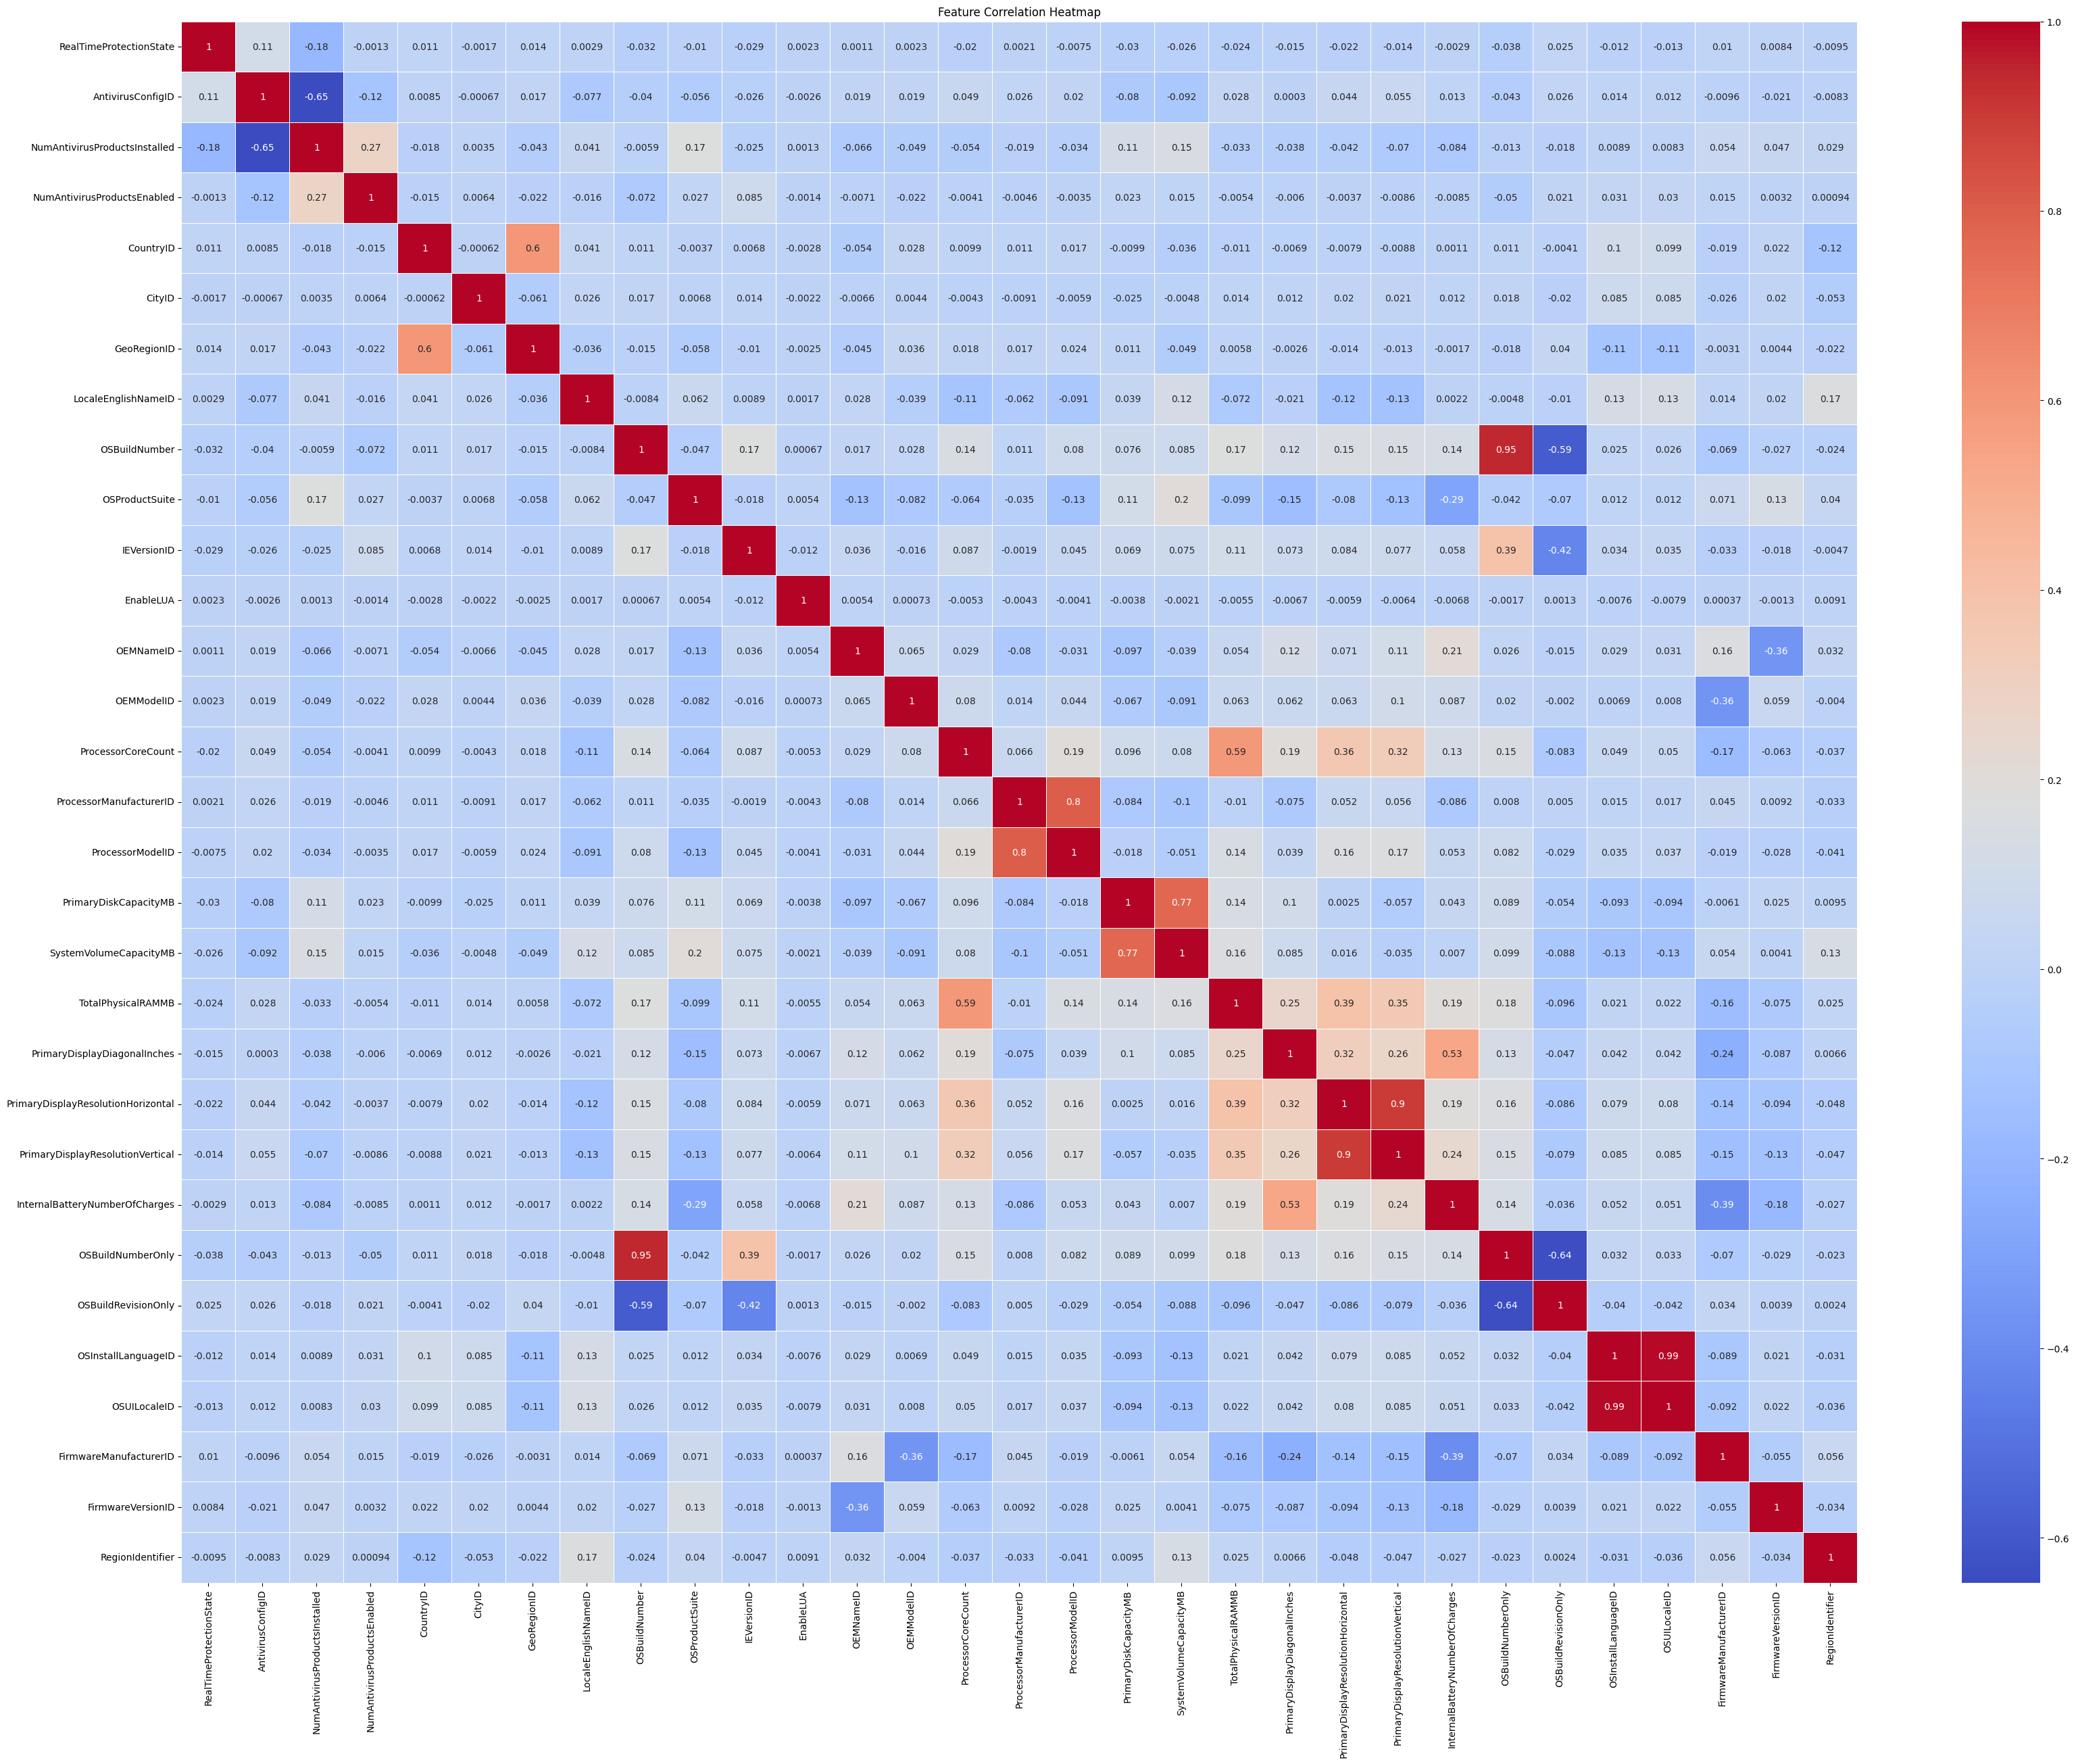

In [59]:
#plot heatmap
plt.figure(figsize=(40, 30))
sns.heatmap(filtered_corr_matrix, cmap="coolwarm", annot=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# 4. Preprocessing

In [60]:
#Seperate the feature and target
X = train_data.drop(columns=['target', 'MachineID'])  # Features (independent variables)
y = train_data['target']  

# Split dataset into  train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Identify numerical and categorical features
num_col = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_col = X_train.select_dtypes(include=['object']).columns


In [61]:
num_col

Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'CityID',
       'GeoRegionID', 'LocaleEnglishNameID', 'OSBuildNumber', 'OSProductSuite',
       'IsSystemProtected', 'AutoSampleSubmissionEnabled', 'SMode',
       'IEVersionID', 'FirewallEnabled', 'EnableLUA', 'OEMNameID',
       'OEMModelID', 'ProcessorCoreCount', 'ProcessorManufacturerID',
       'ProcessorModelID', 'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutionVertical', 'InternalBatteryNumberOfCharges',
       'OSBuildNumberOnly', 'OSBuildRevisionOnly', 'OSInstallLanguageID',
       'OSUILocaleID', 'IsPortableOS', 'IsFlightsDisabled',
       'FirmwareManufacturerID', 'FirmwareVersionID', 'IsSecureBootEnabled',
       'IsVirtua

In [62]:
cat_col

Index(['ProductName', 'EngineVersion', 'AppVersion', 'SignatureVersion',
       'PlatformType', 'Processor', 'OSVersion', 'OsPlatformSubRelease',
       'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily',
       'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole',
       'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition',
       'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName',
       'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS',
       'DateOS'],
      dtype='object')

# Making Pipeline

In [63]:
# # Define pipeline for numerical columns and impute missing values with median 
# numeric_transformer = Pipeline(steps=[
#     ('imputer_median', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# #Define pipeline for categorical columns
# categorical_transformer = Pipeline(steps = [
#     ('imputer_mf', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(handle_unknown = 'ignore', sparse_output=False))
# ])

# # Combine both into a ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[
#     ('numeric', numeric_transformer, num_col),
#     ('catagorical', categorical_transformer, cat_col),
# ])

# Model 1 : Logistic Regression

In [64]:
# # Define final pipeline 
lr_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr", LogisticRegression(random_state=42, solver='liblinear', max_iter=2000))
])


# Fit the pipeline
lr_model = lr_pipeline.fit(X_train, y_train)
lr_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'City...
       'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily',
       'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole',
       'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition',
       'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName',
       'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS',
       'DateOS'],
      dtype='object'))])),
                ('lr',
                 LogisticRegression(max_iter=2000, random_state=42,
                                    solver='liblinear'))])

In [65]:
# # Transform test data using the same pipeline
y_pred_lr = lr_model.predict(X_test) 


In [66]:
# Calculate accuracy
accuracy1 = accuracy_score(y_test, y_pred_lr)
accuracy1


0.6108

**Classification Report:**

accuracy = TP+TN/TP+TN+FP+FN

precision = TP/TP+TFP

recall = TP/TP+FN

f1_score = 2* [( precision * recall ) / ( precision + recall )]

In [67]:
# Classification Report

print("\n Classfication Report:")
print(classification_report(y_test, y_pred_lr))


 Classfication Report:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59      9895
           1       0.61      0.66      0.63     10105

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



In [68]:
# Confusion Matrix
confusion_matrix(y_test, y_pred_lr)

array([[5538, 4357],
       [3427, 6678]])

In [69]:
#Apply the Model on test dataset
test_pred = lr_model.predict(test_set)

In [70]:
# Submit the model
# submission = pd.DataFrame({"id": range(0,test_set.shape[0]), "target": test_pred}) 

# submission.to_csv('submission.csv',index=False)
# print(submission.head(5))

# Model 2: XGBoostClassifier

In [71]:
# Define pipeline on XGBclassifier
xgb_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("xgbc", XGBClassifier(
        random_state = 42,
        n_estimators = 500,
        learning_rate = 0.05,
        max_depth = 6))
])
#fit the pipeline on X_train and y_train
xgb_model = xgb_pipeline.fit(X_train, y_train)
xgb_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'Cit...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [72]:
# Predict the model
y_pred_xgb = xgb_model.predict(X_test)

In [73]:
#Calculate Accuracy
accuracy2 = accuracy_score(y_test, y_pred_xgb)
accuracy2

0.62485

In [74]:
#Classification Report

print("Classification Report")
print(classification_report(y_test, y_pred_xgb))

Classification Report
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      9895
           1       0.62      0.68      0.65     10105

    accuracy                           0.62     20000
   macro avg       0.63      0.62      0.62     20000
weighted avg       0.63      0.62      0.62     20000



In [75]:
# Confusion Matrix
confusion_matrix(y_test,y_pred_xgb)

array([[5656, 4239],
       [3264, 6841]])

In [76]:
#Apply the Model on test dataset
test_pred = xgb_model.predict(test_set)


In [77]:
# # Submit the Model
# submission = pd.DataFrame({"id": range(0,test_set.shape[0]), "target": test_pred}) 

# submission.to_csv('submission.csv',index=False)
# print(submission.head(5))

# Model 3: Random Forest Classifier and Hyperparameter tuning using RandomizedSearchCV

In [103]:
# Making Pipeline for Random Forest Classifier model

# Define pipeline for numerical columns and impute missing values with mean

num_transformer = Pipeline(steps=[
    ('imputer_median', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Define pipeline for categorical columns
cat_transformer = Pipeline(steps = [
    ('imputer_mf', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1))
])

# Combine both into a ColumnTransformer
preprocessor_ = ColumnTransformer(transformers=[
    ('numeric', num_transformer, num_col),
    ('categorical', cat_transformer, cat_col)
    
])

In [104]:
# Define the Pipeline on RandomForestclassifier

rf_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor_),
    ("rf", RandomForestClassifier(random_state= 42, n_jobs = -1))
])

In [ ]:

# Define the hyperparameter search space
param_dist = {
    "rf__n_estimators": [50, 100],  # Number of trees
    "rf__max_depth": [10, 20],  # maximun Depth of trees
    "rf__min_samples_split": [2, 5],  # Minimum samples to split a node
    "rf__min_samples_leaf": [2, 4],  # Minimum samples per leaf
    "rf__bootstrap": [True],  # Sampling method
}


# Perform Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_dist,
    n_iter=10, 
    scoring="accuracy",
    cv=3,  
    verbose=2,
    random_state=42,
    n_jobs=4,
    error_score='raise'
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters & best accuracy
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
#Train the model with best parameters
best_rf = random_search.best_estimator_

#Fit the model on training data
best_rf.fit(X_train, y_train)

In [ ]:
Predict the model

y_pred_rf = best_rf.predict(X_test)

In [ ]:
# Accuracy Score
accuracy3 = accuracy_score(y_test, y_pred_rf)
accuracy3
# 0.62

In [ ]:
# Random forest classificaton report
print("Classification Report")
print(classification_report(y_test, y_pred_rf))

In [ ]:
# Confusion Matrix
confusion_matrix(y_test,y_pred_rf)

In [ ]:
#Apply the Model on test dataset

test_pred = best_rf.predict(test_set)

In [ ]:
# Submit the Model
# submission = pd.DataFrame({"id": range(0,test_set.shape[0]), "target": test_pred}) 
# submission.to_csv('submission.csv',index=False)
# print(submission.head(5))

# Model 4: LightGBM Classifier

In [92]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lgbm', LGBMClassifier(n_jobs = -1))
])
lgbm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'City...
       'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily',
       'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole',
       'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition',
       'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName',
       'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS',
       'DateOS'],
      dtype='object'))])),
                ('lgbm', LGBMClassifier(n_jobs=-1))])

In [93]:
lgbm_model = lgbm_pipeline.fit(X_train, y_train)
lgbm_model

[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.447192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7982
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 2247
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['IsBetaUser', 'RealTimeProtectionState', 'IsPassiveModeEnabled',
       'AntivirusConfigID', 'NumAntivirusProductsInstalled',
       'NumAntivirusProductsEnabled', 'HasTpm', 'CountryID', 'City...
       'OSBuildLab', 'SKUEditionName', 'MDC2FormFactor', 'DeviceFamily',
       'PrimaryDiskType', 'ChassisType', 'PowerPlatformRole',
       'NumericOSVersion', 'OSArchitecture', 'OSBranch', 'OSEdition',
       'OSSkuFriendlyName', 'OSInstallType', 'AutoUpdateOptionsName',
       'OSGenuineState', 'LicenseActivationChannel', 'FlightRing', 'DateAS',
       'DateOS'],
      dtype='object'))])),
                ('lgbm', LGBMClassifier(n_jobs=-1))])

In [94]:
lgbm_y_pred = lgbm_model.predict(X_test)

In [95]:
accuracy4 = accuracy_score(y_test,lgbm_y_pred)
accuracy4

0.6287

In [96]:
# LightGBM classificaton report
print("Classification Report")
print(classification_report(y_test,  lgbm_y_pred))

array([1, 0, 1, ..., 0, 1, 0])

In [97]:
# Confusion Matrix
confusion_matrix(y_test,lgbm_y_pred )

array([[5792, 4103],
       [3323, 6782]])

In [99]:
#Apply the Model on test dataset
test_pred = lgbm_model.predict(test_set)

In [ ]:
# # Submit the Model
# submission = pd.DataFrame({"id": range(0,test_set.shape[0]), "target": test_pred}) 
# submission.to_csv('submission.csv',index=False)
# print(submission.head(5))

# Model 0 (Dummy Model)

In [ ]:
# X_test = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [ ]:
# X = df.drop("target", axis = 1)
# y = df["target"]

In [ ]:
# from sklearn.dummy import DummyClassifier
# model = DummyClassifier().fit(X,y)
# y_pred = model.predict(X_test)

In [ ]:
# submission = pd.DataFrame({"id": range(0,X_test.shape[0]),"target": y_pred})
# submission.to_csv('submission.csv',index = False)
# print(submission.csv)

# Performance Comparison

**After train the model I got highest accuracy in LightGBMClassifier which is 0.6287**